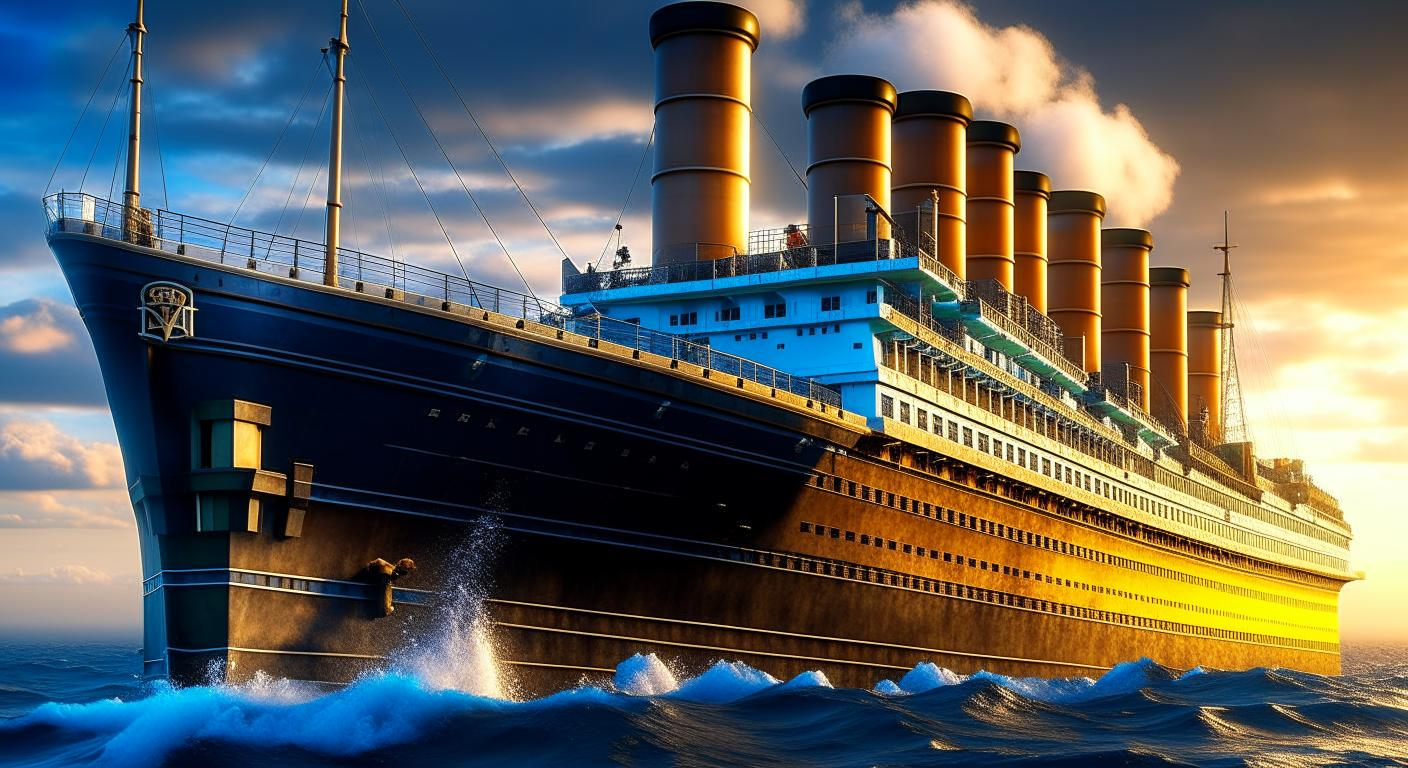

# Hello, fellow data enthusiasts 🤓!

In this notebook you will find several new things that might be of your interest:
- A genuine brand new original authentic feature __'other_people_in_the_ticket_survived'__ that turned out to be informative and highly correlated with the target value.
- A function to make a correlation table for categorical features, based on __Cramer's V coefficient__, which is a tedious and clumsy tool for those, who don't know how to use logreg.coef() (me)
- An elegant pipeline
- VotingClassifier() at work

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions </strong> <br> 
    </blockquote>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from imblearn.combine import SMOTEENN

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

In [2]:
# Check for the data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Data upload
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv ('/kaggle/input/titanic/test.csv')

df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Functions

In [4]:
# missing values visualization
def missing_values(x):
    return (x.isna().sum() / len(x)).sort_values(ascending=False)

# separation of features per dtypes
def types_sep (data):
    numerical = data.select_dtypes(include=['int64','Int32','int16','float64']).columns
    categorical = data.select_dtypes(include=['object','category']).columns
    return {'numerical':numerical, 'categorical':categorical}

# filling in numerical and categorical missing data
def fill_in_gaps(data):
    for feat in types_sep(data)['numerical']:
        data.loc[:, feat] = data[feat].fillna(data[feat].median())
    for feat in types_sep(data)['categorical']:
        data.loc[:, feat] = data[feat].fillna(data[feat].mode()[0])     
    
# outliers control
def boundaries (data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    return q25 - 1.5 * iqr, q75 + 1.5 * iqr 

# data cleanliness check
def data_cleanliness_check (before, now):
    duplicates = now.duplicated()
    missing_values = [now[f].isna().sum() for f in now.columns.tolist()]
    outliers = [((now[f]<boundaries(now[f])[0])|(now[f]>boundaries(now[f])[1])).sum() \
                for f in types_sep(now)['numerical']]      
    rows_diff = len(before)-len(now)
    column_diff = before.shape[1] - now.shape[1]
    
    print (f'duplicates: {duplicates.sum()}\n'
           f'missing values: {sum(missing_values)}\n'
           f'outliers: {sum(outliers)}\n'
           f'rows deleted: {rows_diff}, share: {rows_diff/len(before):.2}\n'
           f'columns deleted: {column_diff}, share: {column_diff/before.shape[1]:.2}')

In [5]:
df_train_clean = df_train.copy()
df_test_clean = df_test.copy()

In [6]:
missing_values(df_train_clean)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [7]:
missing_values(df_test_clean)

Cabin          0.782297
Age            0.205742
Fare           0.002392
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Embarked       0.000000
dtype: float64

In [8]:
# 'Cabin' contains 78% missing values.
df_train_clean.drop(columns = ['Cabin'], inplace=True)
df_test_clean.drop(columns = ['Cabin'], inplace=True)
df_train_clean.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [9]:
'''
The feature 'Fare' contains some outliers, but these values 
are more indicative of the pricing policy rather than being 
a reflection of data quality.
'''

fill_in_gaps(df_train_clean)
data_cleanliness_check (df_train, df_train_clean)

duplicates: 0
missing values: 0
outliers: 441
rows deleted: 0, share: 0.0
columns deleted: 1, share: 0.083


In [10]:
fill_in_gaps(df_test_clean)
data_cleanliness_check (df_test, df_test_clean)

duplicates: 0
missing values: 0
outliers: 196
rows deleted: 0, share: 0.0
columns deleted: 1, share: 0.091


# Feature Engineering

In [11]:
'''
This new feature tests the assumption of a cooperative effect by considering other people who were mentioned on the ticket and managed to survive. 
It aims to explore whether there is a survival correlation among individuals who were listed together on the ticket. 
And this is the promissed new feature that I haven't seen in any other notebook
'''

def other_people_in_the_ticket_survived (data, df_full):
    df_full['Other_people_in_the_ticket_survived'] = df_full.groupby('Ticket')['Survived'].transform(lambda x: 1 if any(x == 1) and len(x) > 1 else 0)
    return data.merge(df_full[['PassengerId', 'Other_people_in_the_ticket_survived']], on='PassengerId', how='left')

# If a passenger had an individual ticket.
# Potentually it may be correlated with fare, cabin_class and/or social cooperation.
def individual_ticket (data, df_full):
    data['Individual_ticket'] = data['Ticket'].apply(lambda x: 1 if df_full['Ticket'].value_counts()[x] == 1 else 0)
    return data

# Relatives on board
def realatives (data):
    data['Relatives'] = data['SibSp'] + data['Parch']
    return data

# categorization of age
def age_category (data):
    data['Age_category'] = data.apply (lambda x: 'child' if x.Age < 18 else \
                                      ('young_adult' if x.Age < 30 else \
                                      ('adult' if x.Age < 60 else 'senior')),
                                       axis = 1)
    return data

# first 3 symboles from "Ticket", structured as a set of categories.
def ticket_type (data):
    data['Ticket_type'] = data['Ticket'].apply(lambda x: x[0:3]).astype('category').cat.codes
    return data

# extracting titles from the names
def get_title(data):
 
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    spellings = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
    
    def extract_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        return title_search.group(1) if title_search else 'no title'
    
    data['Title'] = data['Name'].apply(extract_title)
    data['Title'] = data['Title'].replace(rare_titles, 'Rare').replace(spellings)
    
    return data

In [12]:
df_train_eng = df_train_clean.copy()
df_test_eng = df_test_clean.copy()
df_full = pd.concat([df_train_clean, df_test_clean])

In [13]:
# Here is where we generate all the new features before studing them in the next section
df_train_eng, df_test_eng = other_people_in_the_ticket_survived(df_train_eng, df_full), other_people_in_the_ticket_survived(df_test_eng, df_full)
individual_ticket (df_train_eng, df_full), individual_ticket (df_test_eng, df_full)
realatives (df_train_eng), realatives (df_test_eng)
age_category (df_train_eng), age_category (df_test_eng)
ticket_type (df_train_eng), ticket_type(df_test_eng)
get_title(df_train_eng), get_title(df_test_eng)

df_train_eng.columns, df_test_eng.columns

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Embarked',
        'Other_people_in_the_ticket_survived', 'Individual_ticket', 'Relatives',
        'Age_category', 'Ticket_type', 'Title'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Embarked', 'Other_people_in_the_ticket_survived',
        'Individual_ticket', 'Relatives', 'Age_category', 'Ticket_type',
        'Title'],
       dtype='object'))

# Correlation study and visualization

In [14]:
'''
Correlation table for categorical features, based on Cramer's V coefficient.
I will be honest with you. I had crafted it some time ago with GPT before I've learned that logreg.coef() is a standard tool for this task.
Although it looks monstrous it still does the thing.
'''

def categoricals_corr(data, target):
    categoricals = types_sep(data)['categorical']

    cat_corr = pd.DataFrame(columns=['feature', 'correlation_with_target', 'level_of_correlation'])

    for feat in categoricals:
        if data[feat].nunique() < 10:
            contingency_table = pd.crosstab(data[target], data[feat])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

            level_of_correlation = 'Weak' if cramers_v < 0.1 \
                                    else 'Moderate' if cramers_v < 0.3 \
                                    else 'Strong'

            new_line = {'feature': feat,
                        'correlation_with_target': cramers_v,
                        'level_of_correlation': level_of_correlation}

            cat_corr.loc[len(cat_corr)] = new_line

    return cat_corr


# Correlation table for numerical features, based on Pearson's r.
def numericals_corr (data, target):
    num_corr = pd.DataFrame (columns = ['feature',
                                        'correlation_with_target',
                                        'level_of_correlation'])
    for feat in types_sep(data)['numerical']:
        corr_value = abs(data[feat].corr(data[target]))
        
        level_of_correlation =  'Weak' if corr_value < 0.2 \
                                else 'Moderate' if corr_value < 0.7 \
                                else 'Strong'
        new_line = {'feature': feat,
                    'correlation_with_target': corr_value,
                    'level_of_correlation': level_of_correlation}

        num_corr.loc[len(num_corr)] = new_line
    
    return num_corr[(num_corr.feature != target)].\
           sort_values('correlation_with_target', ascending=False)


# Visualization of features' correlation with the target
def corr_hist(data):
    data = data.sort_values('correlation_with_target', ascending=True)
    color_mapping = {'Weak': 'Salmon',
                     'Moderate': 'Beige',
                     'Strong': 'Teal'}
    plt.figure(figsize=(6, 6))
    plt.barh(data.feature, abs(data.correlation_with_target), color=data['level_of_correlation'].map(color_mapping))
    plt.xlabel('Correlation with Target')
    plt.ylabel('Feature')
    plt.title('Correlation of Features with Target')
    legend_handles = [Patch(facecolor=color, label=level) for level, color in color_mapping.items()]
    plt.legend(handles=legend_handles,loc='lower right')
    plt.show()
    
# This function drops weakly correlated features     
def drop_weak_corr_feat (data, corr_df, significance_level):
    list_to_drop = corr_df[(corr_df.correlation_with_target < significance_level)].feature.tolist() 
    data.drop(columns = list_to_drop, inplace=True)
    print (f'feaures dropped: \n{list_to_drop}')

In [15]:
# Correlation table for categorical features, based on Cramer's V coefficient
cat_corr = categoricals_corr(df_train_eng, 'Survived')
cat_corr

,feature,correlation_with_target,level_of_correlation
0,Sex,0.540936,Strong
1,Embarked,0.170707,Moderate
2,Age_category,0.151417,Moderate
3,Title,0.568652,Strong


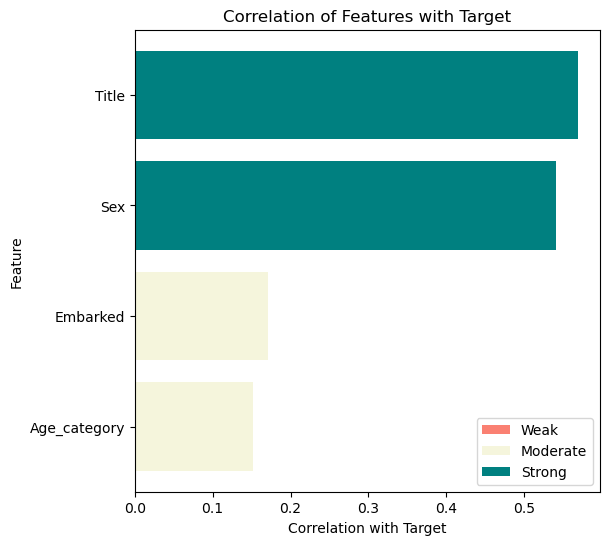

In [16]:
# Visualisation of the above table for the categoricals
corr_hist (cat_corr)

In [17]:
num_corr = numericals_corr (df_train_eng, 'Survived')
num_corr

,feature,correlation_with_target,level_of_correlation
7,Other_people_in_the_ticket_survived,0.551702,Moderate
2,Pclass,0.338481,Moderate
6,Fare,0.257307,Moderate
8,Individual_ticket,0.252939,Moderate
10,Ticket_type,0.168794,Weak
5,Parch,0.081629,Weak
3,Age,0.064910,Weak
4,SibSp,0.035322,Weak
9,Relatives,0.016639,Weak
0,PassengerId,0.005007,Weak


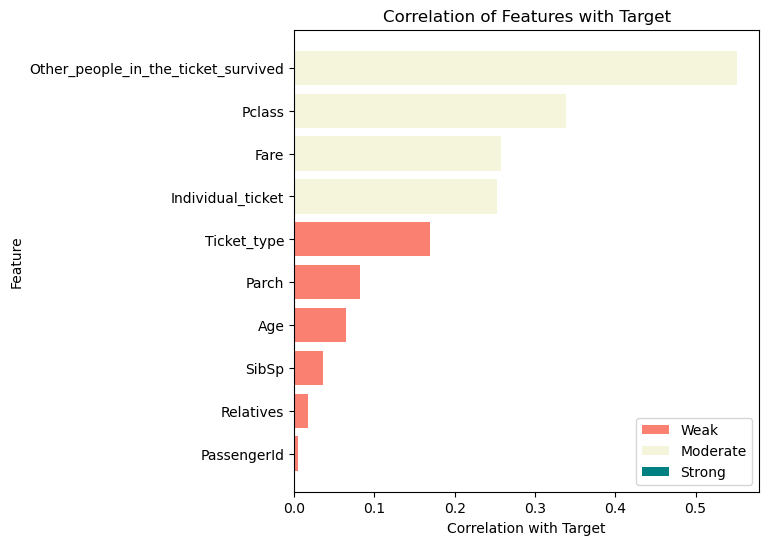

In [18]:
# Visualisation of the above table for the numericals
corr_hist (num_corr)

# GridSearch
This section may appear redundant in the notebook as the dataset is too small to perform cross-validation effectively. Most models yield a perfect accuracy score of 1.0 regardless of the hyperparameters. 

However, the section will be retained for the sake of thoroughness and due diligence.

In [19]:
# hyperparameters for the grid search
grid_search_params = {LogisticRegression(): {
                        'max_iter':[100, 300],
                        'C': [1.0, 0.6],
                        'penalty': ['l2', 'l1'],
                        # 'class_weight': ['balanced', None]
                    },
                    RandomForestClassifier(): {
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'class_weight': ['balanced',None]
                    },
                    AdaBoostClassifier(): {
                        'n_estimators': [50, 200],
                        'learning_rate': [0.1, 0.001]
                    },
                    GradientBoostingClassifier(): {
                        'learning_rate': [0.1, 0.001],
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'class_weight': ['balanced']
                    },
                    XGBClassifier(): {
                        'learning_rate': [0.1, 0.001],
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'scale_pos_weight': [10, 100]
                    }}

#Vectorization and Standardization
def vectorize_n_std(data):
    categorical = types_sep(data)['categorical']
    data_cat_to_dummies = pd.get_dummies(data[categorical], sparse=True)

    scaler = StandardScaler()
    numerical = types_sep(data)['numerical']
    data_std = pd.DataFrame(scaler.fit_transform(data[numerical]), columns=numerical)

    return data_cat_to_dummies, data_std


# Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors technique
def smoteenn(data):
    df = data.drop('Survived', axis=1)
    data_cat_to_dummies, data_std = vectorize_n_std(data)
    X = pd.concat([data_cat_to_dummies, data_std], axis=1)
    y = data['Survived']
    sm = SMOTEENN(random_state=34)
    X, y = sm.fit_resample(X, y)
    return X, y


# Search for the best model and it's best parameters
def grid_search (data):
    
    X,y = smoteenn (data)

    best_score = .0
    best_model = None
    best_params = None
   
    for model in grid_search_params.keys():
        estimator = model
        GS = GridSearchCV(estimator=estimator,
                          param_grid=grid_search_params[model],
                          scoring='accuracy',
                          cv=5,
                          verbose=4)
        GS.fit(X, y)
        print (f'model: {type(model).__name__}, best score: {GS.best_score_}')
        if GS.best_score_ > best_score:
            best_score = GS.best_score_
            best_model = GS.best_estimator_
            best_params = GS.best_params_
            
    print (f'best model: {best_model}\n'
           f'best score: {best_score:.4f}\n'
           f'best parameters: {best_params}')

In [20]:
# grid_search(df_modeling)

# Pipeline

In [21]:
# Feature Engeneering and sorting the relevant ones
def features_generator(data): 
    data = other_people_in_the_ticket_survived (data, df_full)
    individual_ticket (data, df_full)
    realatives (data)
    age_category (data)
    ticket_type (data)
    get_title(data)
    
    #This is the list of features that show strong and moderate correlations with the target variable
    return data[['Title', 'Sex', 'Embarked', 'Age_category','Other_people_in_the_ticket_survived','Pclass', 'Fare','Individual_ticket']]



# Pipeline
def prediction (model, df_for_training, df_for_prediction):
    
    transformer = ColumnTransformer(transformers=[
        ('numerical', StandardScaler(), make_column_selector (dtype_include=['int64', 'float64'])),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include = object))
    ])
    
    pipe = Pipeline(steps=[ 
        ('features_generator', FunctionTransformer(features_generator)),
        ('transformer', transformer),
        ('classifier', model)
    ])

    X, y = df_for_training.drop('Survived', axis=1), df_for_training['Survived']
    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42)
  
    pipe.fit(X_train, y_train)
    y_predict = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print (f'accuracy score on a very small test sample: {accuracy:.2}')
    
    pipe.fit (X,y)

    answer = pd.DataFrame({
            "PassengerId": df_for_prediction["PassengerId"],
            "Survived": pipe.predict(df_for_prediction)
    })
    print (f'resulting dataframe: {answer.shape}')
    
    return answer

def export (df):
    path='submission.csv'
    print (f"Answer exported to {path}")
    return answer.to_csv(path, index=False) 

In [22]:
df_train_pipe = df_train_clean.copy()
df_test_pipe = df_test_clean.copy()

In [23]:
model = VotingClassifier(estimators=[ 
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42)), 
    ('GradientBoostingClassifier',GradientBoostingClassifier(min_samples_split=20, min_samples_leaf=60, max_depth=3, max_features=7, random_state=42)),
    ('SVC',SVC(probability=True, random_state=42))],
                         voting='soft')

answer = prediction (model, df_train_pipe, df_test_pipe)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


accuracy score on a very small test sample: 0.89


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


resulting dataframe: (418, 2)


In [24]:
export(answer)

Answer exported to submission.csv


If you liked this notebook, please also check the others:
 - [🗺️Geospatial Analysis Course: Practical Guide](https://www.kaggle.com/ivanlydkin/geospatial-analysis-course-practical-guide)
 - [🕒Time Series Course: A Practical Guide](https://www.kaggle.com/code/ivanlydkin/time-series-course-a-practical-guide)
 - [🤖 Computer Vision course: Practical Guide](https://www.kaggle.com/ivanlydkin/computer-vision-course-practical-guide/edit)

*I hope it was helpful* 🤝<br>
<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions</strong> </blockquote><br> 